# FFNN
Training auf IDS18 80%  
Validierung auf IDS18 10%   
Test auf IDS18 10%  
Test auf IDS17 folgt in nächstem Skript

In [16]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [18]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(ids18_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-23 20:16:10 - INFO - Class distribution
Label
BENIGN                          2967676
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


(5417706, 51)
Index(['Total TCP Flow Time', 'Fwd IAT Total', 'Fwd Header Length', 'Idle Std',
       'Bwd Header Length', 'Dst Port', 'ECE Flag Count', 'Fwd IAT Max',
       'Fwd Packet Length Max', 'Fwd PSH Flags', 'Fwd Bulk Rate Avg',
       'Protocol', 'Bwd Packet Length Min', 'Bwd Init Win Bytes',
       'Flow Bytes/s', 'Fwd IAT Mean', 'FWD Init Win Bytes',
       'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Bwd IAT Std',
       'Bwd IAT Min', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
       'Bwd Packet Length Std', 'Bwd URG Flags', 'Flow IAT Mean',
       'Fwd IAT Min', 'Subflow Bwd Packets', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Bwd PSH Flags', 'Flow IAT Max', 'FIN Flag Count',
       'SYN Flag Count', 'Bwd IAT Total', 'Bwd Segment Size Avg',
       'Down/Up Ratio', 'Total Fwd Packet', 'Packet Length Variance',
       'Fwd URG Flags', 'Flow IAT Min', 'Active Min', 'Bwd IAT Mean',
       'Bwd Packets/s', 'Bwd RST Flags', 'RST Flag Count', 'Active Std',
       'S

### Trennen von Features und Labels

In [19]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (5417706, 50)
Form von y: (5417706,)


### Label Encoding für y

In [20]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [21]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (4334164, 50)
Form von X_val: (541771, 50)
Form von X_test: (541771, 50)


### Skallierung von X

In [22]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Überprüfen der Klassenverteilung

In [23]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 2374140 Beispiele (54.78%)
  Klasse 1: 114337 Beispiele (2.64%)
  Klasse 2: 231462 Beispiele (5.34%)
  Klasse 3: 18048 Beispiele (0.42%)
  Klasse 4: 1442528 Beispiele (33.28%)
  Klasse 5: 6792 Beispiele (0.16%)
  Klasse 6: 71499 Beispiele (1.65%)
  Klasse 7: 75358 Beispiele (1.74%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8937 Beispiele (1.65%)
  Klasse 7: 9420 Beispiele (1.74%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8938 Beispiele (1.65%)
  Klasse 7: 9419 Beispiele (1.74%)



 ### Modell erstellen und trainieren

In [24]:
num_features = len(X_train.columns)  # Anzahl der Merkmale
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# Definiere das Modell
model = Sequential([
    InputLayer(shape=(num_features,), name = 'Input-Layer'),  # Eingabeschicht
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), name = 'Dense-Layer-1'),  # Erste versteckte Schicht mit l2-Regularisierung
    Dropout(0.3, name = 'Dropout-Layer'),  # Vermeidung von Overfitting
    Dense(32, activation='relu', name = 'Dense-Layer-2'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax', name = 'Output-Layer')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-Layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-2 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,608 (21.91 KB)

 Trainable params: 5,608 (21.91 KB)

 Non-trainable params: 0 (0.00 B)

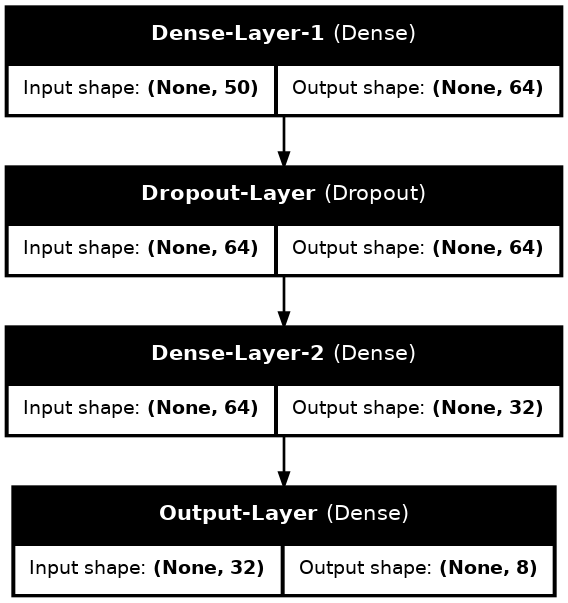

In [25]:
# Modell visualisieren und als PNG speichern
plot_model(
    model, 
    to_file='model_structure.png',  # Speicherort der Grafik
    show_shapes=True,  # Zeigt die Form der Tensoren an
    show_layer_names=True,  # Zeigt die Namen der Schichten an
    dpi=96  # Auflösung
)


### Trainieren des Modells

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 174s 1ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0125 - val_sparse_categorical_accuracy: 0.9982
Epoch 2/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 168s 1ms/step - loss: 0.0166 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0127 - val_sparse_categorical_accuracy: 0.9979
Epoch 3/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 172s 1ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0123 - val_sparse_categorical_accuracy: 0.9977
Epoch 4/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 163s 1ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0122 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 166s 1ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0131 - val_sparse_categorical_accuracy: 0.9977
Epoch 6/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 161s 1ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.012

### Trainingsverlauf plotten

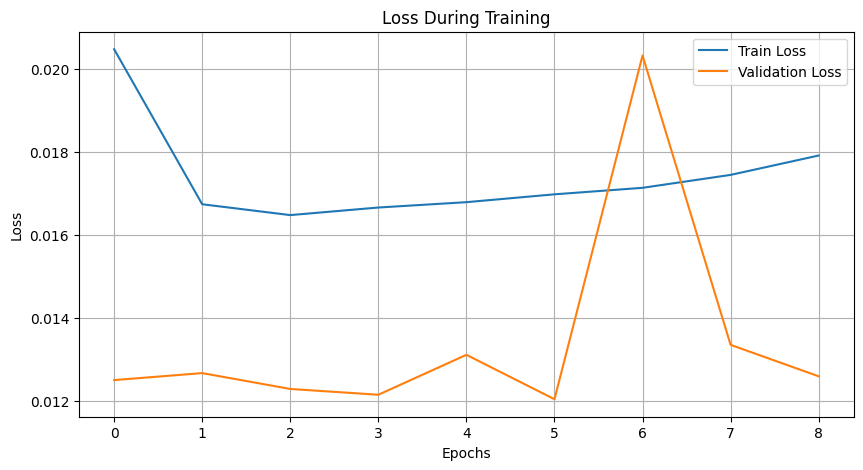

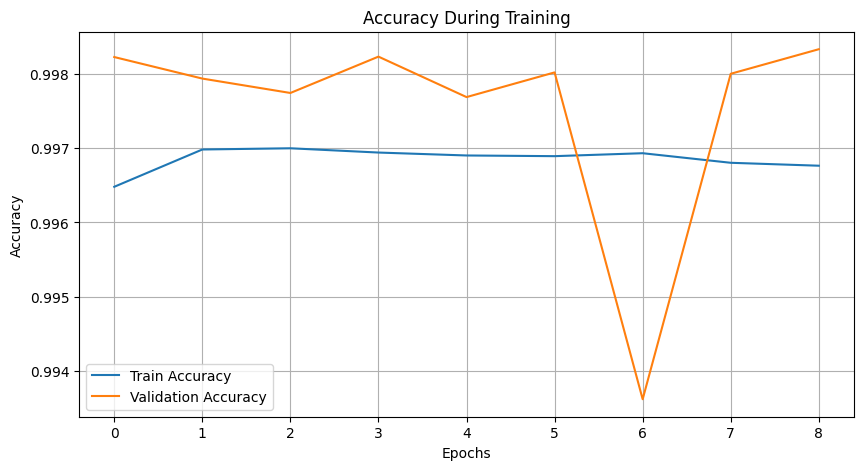

In [27]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz

#### Klassifikationsbericht und Konfusionsmatrix

In [28]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

16931/16931 ━━━━━━━━━━━━━━━━━━━━ 13s 785us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    296768
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       1.00      0.94      0.97       849
Infiltration - NMAP Portscan       0.96      0.93      0.95      8938
              SSH-BruteForce       1.00      1.00      1.00      9419

                    accuracy                           1.00    541771
                   macro avg       0.99      0.98      0.99    541771
                weighted avg       1.00      1.00      1.00    541771



Visualisierung der Konfusionsmatrix

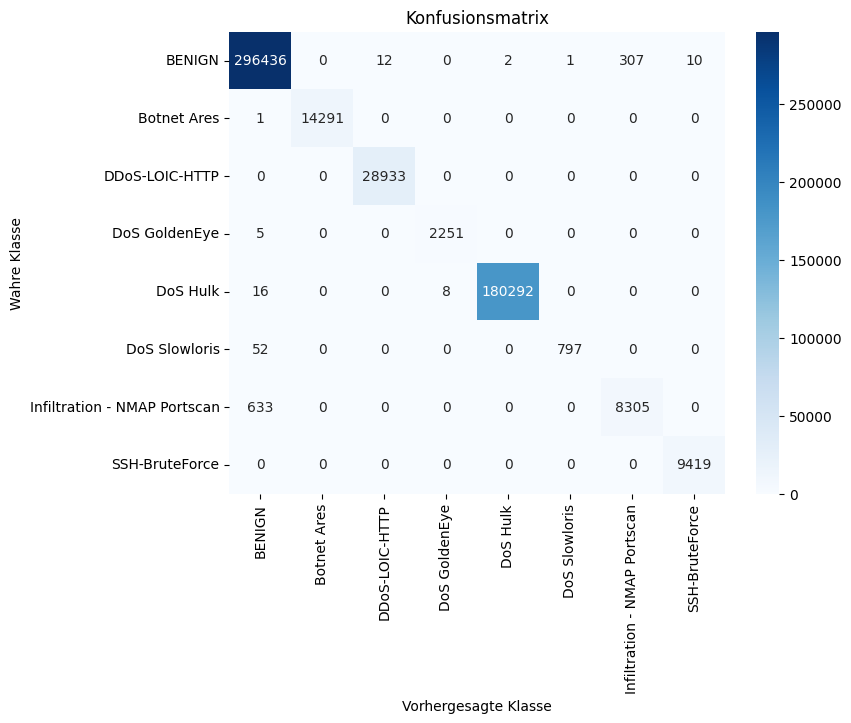

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern von Modell, Encoder und Scaler

In [30]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']